In [2]:
text = 'You say goodbye and I say hello.'

In [3]:
text = text.lower()
text = text.replace('.', ' .')
print(text)

words = text.split(' ')
print(words)

you say goodbye and i say hello .
['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']


In [4]:
word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word

In [5]:
print(id_to_word)
print(word_to_id)

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}


In [6]:
import numpy as np

corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [19]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}

    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

In [8]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

corpus, word_to_id, id_to_word

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']


(array([0, 1, 2, 3, 4, 1, 5, 6]),
 {'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6},
 {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'})

In [9]:
# Window Size = 1
C = np.array([
    [0, 1, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 1, 1, 0],
    [0, 1, 0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 1, 0]
], dtype=np.int32)
C

array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]])

In [10]:
print(C[0])
print(C[4])
print(C[word_to_id['goodbye']])

[0 1 0 0 0 0 0]
[0 0 0 0 0 1 0]
[0 1 0 1 0 0 0]


## Co-Occurence Matrix -> Problem : Not related token can get high value

In [11]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size+1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix

## Cosine Similarity

In [12]:
def cos_similarity(x, y, eps = 1e-8):
    nx = x / np.sqrt(np.sum(x**2) + eps)
    ny = y / np.sqrt(np.sum(y**2) + eps)
    return np.dot(nx, ny)

In [13]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]
print(cos_similarity(c0, c1))
print(c0)
print(np.sum(c0 ** 2))

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']
0.7071067758832467
[0 1 0 0 0 0 0]
1


In [14]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    if query not in word_to_id:
        print(f"{query} can't not find")
        return
    print("\n[query]" + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue

        print(f"{id_to_word[i], similarity[i]}")

        count += 1

        if count >= top:
            return

In [15]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

most_similar('you', word_to_id, id_to_word, C, top=5)

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

[query]you
('goodbye', 0.7071067758832467)
('i', 0.7071067758832467)
('hello', 0.7071067758832467)
('say', 0.0)
('and', 0.0)


## PPMI : Co-occurence problem Solution

In [16]:
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)

    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / S[j]*S[i] + eps)
            M[i, j] = max(0, pmi)
            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print(f"{100*cnt/total} 완료")

    return M

In [17]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3)
print(C)
print("-"*100)
print(W)

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
----------------------------------------------------------------------------------------------------
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [5.807 0.    4.807 0.    4.807 4.807 0.   ]
 [0.    2.807 0.    3.807 0.    0.    0.   ]
 [0.    0.    3.807 0.    3.807 0.    0.   ]
 [0.    2.807 0.    3.807 0.    0.    0.   ]
 [0.    2.807 0.    0.    0.    0.    4.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


#### PPMI's Problem <br> 1. 어휘 수 증가 -> 벡터의 차원 수 증가 <br> 2. 벡터 원소 대부분 0 == 대부분 중요하지 않은 정보

#### Solution : Dimensionality Reduction

## SVD

In [22]:
import numpy as np
import matplotlib.pyplot as plt

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(id_to_word)
C = create_co_matrix(corpus, vocab_size, window_size=1)
W = ppmi(C)

U, S, V = np.linalg.svd(W)
U.shape, S.shape, V.shape

((7, 7), (7,), (7, 7))

In [23]:
print(C[0])
print(W[0])
print(U[0])

[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[ 0.000e+00  1.748e-01  3.821e-02 -1.110e-16 -1.110e-16 -9.839e-01
  6.621e-16]


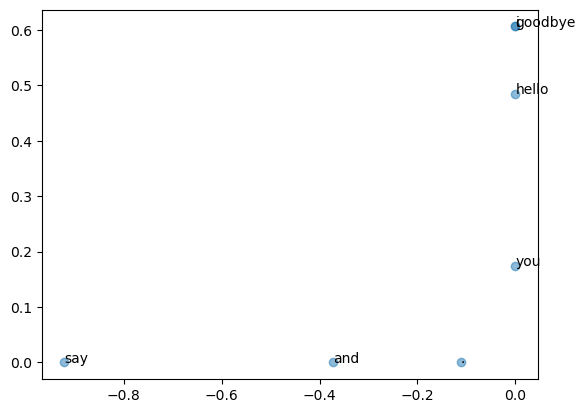

In [26]:
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))

plt.scatter(U[:,0], U[:, 1], alpha=0.5)
plt.show()

## Using PTB Dataset

In [29]:
import sys
import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')

print(len(corpus))

print(id_to_word[0])
print(id_to_word[1])
print(id_to_word[2])

print(word_to_id['car'])
print(word_to_id['happy'])
print(word_to_id['lexus'])

929589
aer
banknote
berlitz
3856
4428
7426


In [30]:
import numpy as np
import ptb

window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('Co-Occurence Operating...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('PPMI Operating...')
W = ppmi(C, verbose=True)

print('SVD Operating...')
try:
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iters=5, random_state=None)

except:
    U, S, V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]

queries = ['you', 'year', 'car', 'lexus']
for query in queries:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

Co-Occurence Operating...
PPMI Operating...


C:\Users\kck\AppData\Local\Temp\ipykernel_21528\3827501272.py:11: RuntimeWarning: overflow encountered in long_scalars
  pmi = np.log2(C[i, j] * N / S[j]*S[i] + eps)
C:\Users\kck\AppData\Local\Temp\ipykernel_21528\3827501272.py:11: RuntimeWarning: invalid value encountered in log2
  pmi = np.log2(C[i, j] * N / S[j]*S[i] + eps)


1.0 완료
2.0 완료
3.0 완료
4.0 완료
5.0 완료
6.0 완료
7.0 완료
8.0 완료
9.0 완료
10.0 완료
11.0 완료
12.0 완료
13.0 완료
14.0 완료
15.0 완료
16.0 완료
17.0 완료
18.0 완료
19.0 완료
20.0 완료
21.0 완료
22.0 완료
23.0 완료
24.0 완료
25.0 완료
26.0 완료
27.0 완료
28.0 완료
29.0 완료
30.0 완료
31.0 완료
32.0 완료
33.0 완료
34.0 완료
35.0 완료
36.0 완료
37.0 완료
38.0 완료
39.0 완료
40.0 완료
41.0 완료
42.0 완료
43.0 완료
44.0 완료
45.0 완료
46.0 완료
47.0 완료
48.0 완료
49.0 완료
50.0 완료
51.0 완료
52.0 완료
53.0 완료
54.0 완료
55.0 완료
56.0 완료
57.0 완료
58.0 완료
59.0 완료
60.0 완료
61.0 완료
62.0 완료
63.0 완료
64.0 완료
65.0 완료
66.0 완료
67.0 완료
68.0 완료
69.0 완료
70.0 완료
71.0 완료
72.0 완료
73.0 완료
74.0 완료
75.0 완료
76.0 완료
77.0 완료
78.0 완료
79.0 완료
80.0 완료
81.0 완료
82.0 완료
83.0 완료
84.0 완료
85.0 완료
86.0 완료
87.0 완료
88.0 완료
89.0 완료
90.0 완료
91.0 완료
92.0 완료
93.0 완료
94.0 완료
95.0 완료
96.0 완료
97.0 완료
98.0 완료
99.0 완료
100.0 완료
SVD Operating...

[query]you
("'ll", 0.5519955158233643)
('me', 0.5087558031082153)
("'ve", 0.49032852053642273)
('going', 0.4876275062561035)
("'d", 0.45917049050331116)

[query]year
('next', 0.4590035676956